In [ ]:
# !conda install -y -n nbenv1 -c conda-forge regionmask cartopy pygeos
#!conda install -y -n nbenv1 nc-time-axis

In [17]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc



%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage0
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.basemap import addcyclic
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [18]:
seas='JJA'
reg='IPCC'
nyear=1
rebasing=False

if (seas == "DJF"):
    sind=1
else:
    sind=0

print(sind)
def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        # print(tmp)
        # print(tmp.shape)
        # print(dates)
        tmp['year']=dates
#         print(tmp.year)
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    # print(dsnew)
    return(dsnew)

def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas):
    season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
    seasindex=season[seas]
    if (seas == 'ann'):
        var_seas=var.groupby('time.year').mean('time')
    else:
        if (var.ndim == 4):
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time') #rename({"time":"year"})
        elif (var.ndim == 3): 
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        print(var_seas)
    return(var_seas)

zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)
# print(zipgmst)
def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)


gmststab=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc')))
gmst=xr.open_mfdataset(gmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
gmst=rebase(gmst,gmststab)
gmstbase=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/gmst/tas_gmst_*.nc'))
gmstref=xr.open_mfdataset(gmstbase,combine='nested',concat_dim='cases')['tas']
base=gmstref[:,0:50].mean('cases').mean('year')
gmst2=gmst-base

    # calculate transient_gmst 

gmstssp=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/gmst/tas_gmst_*.nc'))
gmstsspt=xr.open_mfdataset(gmstssp,combine='nested',concat_dim='cases')['tas']
gmstssp370=gmstsspt-base

0
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bu607.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_fi

In [38]:
seas='JJA'
var='pr'
r=16
stable={}
transient={}
stable_r={}
stable['pr']=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['pr_region_mean'][:,:,r]
print(stable['pr'].shape)
transient['pr']=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_transient.nc')['pr_region_mean'][:,:,r]
print(np.mean(transient['pr'][:,-10:],axis=(0,1)).values)
region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['names'][r].values
print(region)

(6, 526)
-7.415631031263279
N.Europe


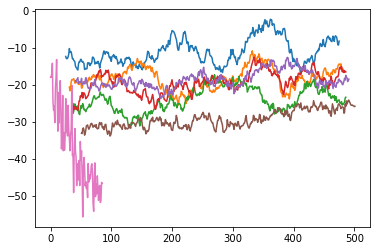

In [31]:
var='pr'
ssp3_real_ind=[1,2,5]
for r in np.arange(0,6):
    plt.plot(stable[var][r,:].rolling(year=50,center=True).mean())
plt.plot(np.nanmean(transient[var],axis=0))

In [33]:
var='pr'
syear=sind+0
eyear=500
spacing=16
stable_r[var]=rebase(stable[var],gmststab)
cmap = plt.cm.get_cmap('summer_r')
cmap2 = plt.cm.get_cmap('BrBG')
col=np.linspace(0.2,1,6)
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(3.8, 2.4), constrained_layout=True,squeeze=False)
ax=axarr.flatten()
ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)
i=0
for r in np.arange(0,6):
    ax[0].scatter(gmst2[r,0:eyear].rolling(year=16,center=True).mean()[::spacing],stable_r[var][r,0:eyear].rolling(year=16,center=True).mean()[::spacing],color=cmap(col[i]),alpha=1)
    fit_stable_1=np.polyfit(x=gmst2[r,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),y=stable_r[var][r,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=1)
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:]**2)+fit_stable_1[1]*gmst2[r,sind:]+fit_stable_1[2]
    recon_s1=fit_stable_1[0]*(gmst2[r,sind:])+fit_stable_1[1]
    ax[0].plot(gmst2[r,sind:],recon_s1,color=cmap(col[i]),linewidth=3)
    i+=1
fit_transient=np.polyfit(x=np.nanmean(gmstssp370[:,:],axis=0),y=np.nanmean(transient[var][:,:].values,axis=0),deg=1)
# recon=fit_transient[0]*((np.nanmean(gmstssp370[:,:],axis=0))**2)+fit_transient[1]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[2]
recon=fit_transient[0]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[1]
ax[0].plot(np.nanmean(gmstssp370[:,:],axis=0),recon,c='brown',linewidth=3)
# ax[0].set_title("UK and Ireland")
# ax[0].scatter(gmstssp370[:,::spacing],transient[:,::spacing],c='brown',alpha=0.6)
# ax[0].scatter(np.mean(gmstssp370,axis=0),np.mean(transient[var],axis=0),c=cmap2(0.1),alpha=0.6)
ax[0].scatter(np.mean(gmstssp370,axis=0),np.mean(transient[var],axis=0),c='brown',alpha=0.6)

# lim=np.round(np.nanmax((np.abs(np.nanmin(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
                        # np.nanmax(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0))),np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0)))),2)
ax[0].set_ylim(ymax = 20., ymin = -65.)
# ax[0].set_ylim(ymax = 20., ymin = -20.)
# ax[0].yaxis.tick_left()
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(np.arange(-65,21, step=20))  # Set label locations.
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[0].set_xlabel('GWL (°C)',fontsize=14)
ax[0].set_ylabel('%',fontsize=14)
ax[0].set_title(str(region))
plt.savefig('paper_plots/pr_regional_sensitivity_'+seas+'_'+str(nyear)+'_'+str(region)+'_deg1.png',dpi=300)

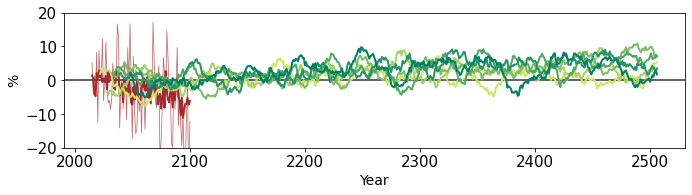

In [6]:
linelist=[]
# fig, axes = plt.subplots(2,2,figsize=(10,2.5))
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.4), constrained_layout=True,squeeze=False) # width was 9
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 2.6), constrained_layout=True,squeeze=False) # width was 9

ax=ax.flatten()
ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)
ax[0].axhline(y=52, color='black', linestyle='-',alpha=0.8)
# ax[0].axhline(y=53, color='black', linestyle='-',alpha=0.8)
for r in np.arange(0,1):
    ax[0].plot(transient[var].year.values,transient[var][r,:].rolling(min_periods=1, center=True, year=1).mean().values,color='brown',linewidth=0.75,alpha=0.7)
lines, = ax[0].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color='brown',linewidth=2)
linelist.append(lines)    
i=0
# for c in ssp3_real_ind:
for c in np.arange(0,6):
    lines,= ax[0].plot(stable[var].year[0:eyear].values,stable[var][c,0:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[i]),linewidth=2,alpha=1)
    linelist.append(lines)
    i+=1
# lim=np.round(np.nanmax((np.abs(np.nanmin(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
#               np.nanmax(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(transient_data[:,:],axis=0))),np.nanmin(np.mean(transient_data[:,:],axis=0)))),2)
# print(lim)
ax[0].set_ylim(ymax = 20, ymin = -20.0)
# ax[0].set_title('Precipitation timeseries for '+str(region))
ax[0].tick_params(axis='both', which='major', labelsize=15)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(np.arange(-20,21, step=10))  # Set label locations.
# xticks([0, 1, 2], ['January', 'February', 'March'],
#        rotation=20)  # Set text labels and properties.
# xticks([])  # Disable xticks.
ax[0].set_xlabel('Year',fontsize=14)
ax[0].set_ylabel('%',fontsize=14)
# ax[0].legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['SSP370 parent transient run','hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370'],frameon=False,fontsize=10,ncol=3)
# ax[0].legend([linelist[1],linelist[2],linelist[3],linelist[0]], ['2020 SSP370','2025 SSP370','2040 SSP370','SSP370 transient EM'],frameon=False,fontsize=10,ncol=3)
#axes[0].legend([linelist[0]], ['UKESM1 SSP3-7.0'],frameon=False,fontsize=10,ncol=3)

plt.savefig('paper_plots/ssp_reg_timeseries_'+seas+'_'+str(region)+'_'+str(nyear)+'_v6.png',dpi=300)


In [25]:
var='jet'
stable[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_stable'].rename({'year_1':'year'}) #,gmststab)
print(stable[var].shape)
transient[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_transient'].rename({'year_2':'year'})
print(stable[var].shape)

(6, 526)
(6, 526)


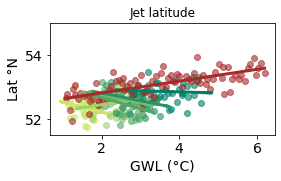

In [28]:
syear=sind+0
eyear=500
spacing=16
stable_r[var]=rebase(stable[var],gmststab)
cmap = plt.cm.get_cmap('summer_r')
col=np.linspace(0.2,1,6)
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(3.8, 2.4), constrained_layout=True,squeeze=False)
ax=axarr.flatten()
# ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)
i=0
# for r in ssp3_real_ind:
for r in np.arange(0,6):
    ax[0].scatter(gmst2[r,syear:eyear].rolling(year=16,center=True).mean()[::spacing],stable_r[var][r,syear:eyear].rolling(year=16,center=True).mean()[::spacing],color=cmap(col[i]),alpha=0.6)
    fit_stable_1=np.polyfit(x=gmst2[r,syear:eyear].rolling(year=1,center=True).mean().dropna('year'),y=stable_r[var][r,syear:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=1)
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:]**2)+fit_stable_1[1]*gmst2[r,sind:]+fit_stable_1[2]
    recon_s1=fit_stable_1[0]*(gmst2[r,sind:])+fit_stable_1[1]
    ax[0].plot(gmst2[r,syear:eyear],recon_s1[syear:eyear],color=cmap(col[i]),linewidth=3)#cmap(col[i]),linewidth=3)
    i+=1
fit_transient=np.polyfit(x=np.nanmean(gmstssp370[:,:],axis=0),y=np.nanmean(transient[var][:,:].values,axis=0),deg=1)
# recon=fit_transient[0]*((np.nanmean(gmstssp370[:,:],axis=0))**2)+fit_transient[1]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[2]
recon=fit_transient[0]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[1]
ax[0].plot(np.nanmean(gmstssp370[:,:],axis=0),recon,c='brown',linewidth=3)
ax[0].set_title("Jet latitude")
# ax[0].scatter(gmstssp370[:,::spacing],transient[:,::spacing],c='brown',alpha=0.6)
ax[0].scatter(np.mean(gmstssp370,axis=0),np.mean(transient[var],axis=0),c='brown',alpha=0.6)

# lim=np.round(np.nanmax((np.abs(np.nanmin(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
                        # np.nanmax(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0))),np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0)))),2)
ax[0].set_ylim(ymax = 55, ymin = 51.5)
ax[0].set_xlabel('GWL (°C)',fontsize=14)
ax[0].set_ylabel('Lat °N',fontsize=14)
# ax[0].yaxis.tick_left()
ax[0].tick_params(axis='both', which='major', labelsize=14)
plt.savefig('paper_plots/jet_regional_sensitivity_'+seas+'_'+str(nyear)+'_v2_short.png',dpi=300)

ValueError: too many values to unpack (expected 1)

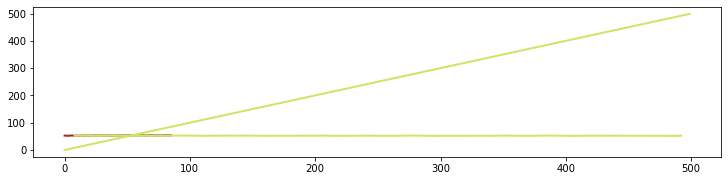

In [9]:
linelist=[]
spacing=1
# fig, axes = plt.subplots(2,2,figsize=(10,2.5))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.4), constrained_layout=True,squeeze=False) # width was 9
ax=ax.flatten()
# ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)
# ax[0].axhline(y=53, color='black', linestyle='-',alpha=0.8)
# ax[0].axhline(y=52.5, color='black', linestyle='-',alpha=0.8)

# ax[0].axhline(y=53, color='black', linestyle='-',alpha=0.8)
for r in np.arange(0,1):
    ax[0].plot(transient[var].year.values,transient[var][r,:].rolling(min_periods=1, center=True, year=1).mean().values,color='brown',linewidth=0.75,alpha=0.7)
lines, = ax[0].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color='brown',linewidth=2)
linelist.append(lines)    
i=0
# for c in ssp3_real_ind:
# jet_d=(stable_r[var]-(xr.polyval(coord=stable_r[var].year,coeffs=stable_r[var].polyfit(dim='year',deg=1)))['polyfit_coefficients']
# lines,= ax[0].plot(stable_r[var].year[syear:eyear].values,np.mean(jet_d[:,syear:eyear].rolling(min_periods=16, center=True, year=16).mean(),axis=0),color=cmap(col[i]),linewidth=2,alpha=1)
# ax[0].axhline(y=np.mean(stable_r[var][:,syear:eyear]), color='black', linestyle='-',alpha=0.8)

for c in np.arange(0,6):
    lines,= ax[0].plot(stable[var][c,].year[syear:eyear].values,stable[var].year[syear:eyear].values,stable[var][c,syear:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[i]),linewidth=2,alpha=1)
    # ax[0].axhline(y=np.mean(stable[var][0,syear:eyear]), color='black', linestyle='-',alpha=0.8)
    # ax[0].scatter(stable[var].year[syear:eyear:spacing].values,stable[var][c,syear:eyear].rolling(min_periods=10, center=True, year=10).mean()[::spacing]) #,color=cmap(col[i]),linewidth=2,alpha=1)
    # axbis = ax[0].twinx()
    # gmstd=(gmst2-(xr.polyval(coord=gmst2[c,].year,coeffs=gmst2[c,].polyfit(dim='year',deg=1))))['polyfit_coefficients']
    # print(gmstd)
    # print(var)
    # axbis.plot(stable[var].year[0:eyear].values,gmstd[c,],linewidth=2,alpha=0.5,c='blue')
    # print(np.corrcoef(gmstd[c,0:eyear].dropna('year').values,stable_r[var][c,0:eyear].dropna('year').values))
    # lines,= ax[0].plot(stable[var].year[0:eyear].values,stable[var][c,0:eyear].rolling(min_periods=1, center=True, year=1).mean(),color=cmap(col[i]),linewidth=2,alpha=1)
    linelist.append(lines)
    fit_stable_1=np.polyfit(x=stable_r[var][c,sind:eyear].year,y=stable_r[var][c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=1)
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:]**2)+fit_stable_1[1]*gmst2[r,sind:]+fit_stable_1[2]
    # recon_s1=fit_stable_1[0]*(stable_r[var][c,sind:eyear].year)+fit_stable_1[1]
    # ax[0].plot(stable_r[var][c,sind:eyear].year,recon_s1,color=cmap(col[i]),linewidth=3)
    i+=1
# lim=np.round(np.nanmax((np.abs(np.nanmin(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
#               np.nanmax(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(transient_data[:,:],axis=0))),np.nanmin(np.mean(transient_data[:,:],axis=0)))),2)
# print(lim)
ax[0].set_ylim(ymax = 55, ymin = 51.5)
ax[0].set_title('Atlantic jet latitude')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel('Year',fontsize=14)
ax[0].set_ylabel('Lat °N',fontsize=14)

# ax[0].legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 parent transient run'],frameon=False,fontsize=10,ncol=3)
# ax[0].legend([linelist[1],linelist[2],linelist[3],linelist[0]], ['2020 SSP370','2025 SSP370','2040 SSP370','SSP370 transient EM'],frameon=False,fontsize=10,ncol=3)
#axes[0].legend([linelist[0]], ['UKESM1 SSP3-7.0'],frameon=False,fontsize=10,ncol=3)

plt.savefig('paper_plots/jetjja_timeseries_'+seas+'_'+reg+'_'+str(nyear)+'_v2_short.png',dpi=300)


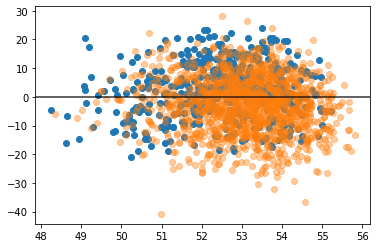

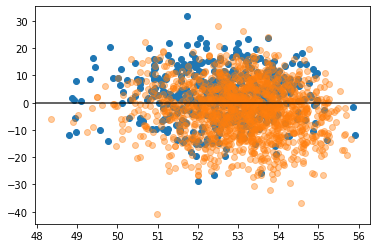

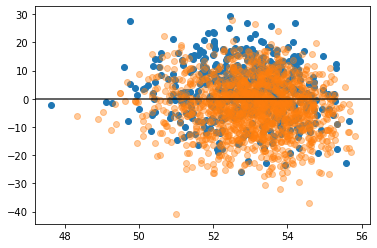

<Figure size 432x288 with 0 Axes>

In [10]:
for r in ssp3_real_ind:
    plt.scatter(stable['jet'][r,:],stable['pr'][r,:])
    plt.scatter(transient['jet'],transient['pr'],alpha=0.4)
    plt.axhline(y=0, color='black', linestyle='-',alpha=0.8)
    plt.figure()

In [11]:
factor={'tas':1,'pr':86400,'txx':1,'psl':1./100,'ua_850':1.,'evspsbl':86400,'va_850':1.,'uas':1.,'vas':1.,'prw':1,'huss':1000,'hurs':1,'mrso':1,'mrsos':1,'ts':1,'rsds':1,'clt':1}
seas='JJA'
var=['tas','psl','ua_850','pr','hurs','mrsos','huss','evspsbl','ts']
def trend_patterns(var):
    if (var == 'ua_850'):
        var2='ua'
    else:
        var2=var
    files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
    tasfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    stable[var]=rebase(seasaverage_3(tasfiles[var2],seas),files)*factor[var]
    
    files=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/'+var+'/'+var+'_*.nc'))
    transientfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    transient[var]=seasaverage_3(transientfiles[var2],seas)*factor[var]
    
    trend=stable[var].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    print(trend.shape)
    trend, lon2 = add_cyclic_point(trend, stable[var].lon, axis=2)
    global_trend=gmst2.polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    transient_trend=transient[var].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    transient_trend, lon2 = add_cyclic_point(transient_trend, transient[var].lon, axis=2)
    transient_gtrend=gmstssp370.polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    global_trend=np.broadcast_to(global_trend[:, np.newaxis, np.newaxis], (6, trend.shape[1], trend.shape[2]))
    transient_gtrend=np.broadcast_to(transient_gtrend[:, np.newaxis, np.newaxis], (16, transient_trend.shape[1], transient_trend.shape[2]))
    print(transient_trend.shape)
    return(trend,transient_trend,transient_gtrend,global_trend,stable[var].lat,lon2)

import pickle
filename = 'multi_var_trends_'+seas
if (os.path.exists(filename)):
    file = open(filename, 'rb')
    trend,transient_trend,transient_gtrend,global_trend,lat,lon = pickle.load(file)
    file.close()
else:
    # if (trend==None):
    print('nothing loaded')
    trend={}
    transient_trend={}
    transient_gtrend={}
    global_trend={}
    lat={}; lon={}
    for var in var[0:8]:
        print(var)
        trend[var],transient_trend[var],transient_gtrend[var],global_trend[var],lat[var],lon[var]=trend_patterns(var)
        print(trend.keys())
    import pickle
    filename = 'multi_var_trends_'+seas
    outfile = open(filename,'wb')
    pickle.dump([trend,transient_trend,transient_gtrend,global_trend,lat,lon],outfile)
    outfile.close()

In [12]:
# import matplotlib.colors as colors
# f=plt.figure()
# crs = ccrs.Robinson(central_longitude=0., globe=None)
# colormap={'tas':plt.cm.RdBu_r,'pr':plt.cm.BrBG,'psl':plt.cm.RdBu_r,'ua_850':plt.cm.RdBu_r,'huss':plt.cm.BrBG,'prw':plt.cm.BrBG,'hurs':plt.cm.BrBG,'evspsbl':plt.cm.BrBG,'mrso':plt.cm.BrBG,'mrsos':plt.cm.BrBG}
# scale={'pr':2,'tas':2,'psl':plt.cm.RdBu_r,'psl':2.,'ua_850':2,'huss':0.001,'prw':5,'hurs':2,'evspsbl':2,'mrso':20,'mrsos':3}

# vmin = -3 
# vmax = 3
# norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

# def plot_background(ax):
#     # if (reg=='glob'):
#     #     ax.set_global()
#     # else:
#     reg='euro'
#     ax.set_extent([-100,50,10,90])
#     ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.)
#     ax.set_anchor('S')
#     # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#     #               linewidth=1, color='black', alpha=1) #, linestyle='')
#     # gl.top_labels = False
#     # gl.bottom_labels = False
#     # gl.left_labels = False
#     # gl.right_labels = False
#     # gl.xlines = False
#     # gl.ylocator = mticker.FixedLocator([0])
#     return ax

# fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(13, 7), constrained_layout=True, subplot_kw={'projection': crs}) # figsize width then height
# axlist = axarr.flatten()
# for ax in axlist:
#     plot_background(ax)

# for r in np.arange(0,trend.shape[0]):
#     cf1 = axlist[r].contourf(lon2,stable[var].lat,(trend[r,]/global_trend[r,]),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# cf1 = axlist[6].contourf(lon2,stable[var].lat,np.mean(trend/global_trend[0:trend.shape[0],],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# if (var == 'ua_850'):
#     cf2 = axlist[6].contour(stable[var].lon,stable[var].lat,np.mean(stable[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
# axlist[6].set_title('EM stable trends')
# cf1 = axlist[7].contourf(lon2,stable[var].lat,np.mean(transient_trend/transient_gtrend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# axlist[7].set_title('EM transient trends')
# if (var == 'ua_850'):
#     cf3 = axlist[7].contour(stable[var].lon,stable[var].lat,np.mean(transient[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
# cf1 = axlist[8].contourf(lon2,stable[var].lat,np.mean(trend/global_trend[0:trend.shape[0],],axis=0)-np.mean(transient_trend/transient_gtrend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# axlist[8].set_title('Difference stable minus transient trends')
# plt.suptitle(seas+" trends in "+var+" divided by trend in GMST")
# fig.colorbar(cf1,ax=axlist[6:9],orientation='vertical',shrink=1)
# if (var == 'ua_850'):
#     axlist[6].clabel(cf2, cf2.levels, inline=True, fontsize=10)
#     axlist[7].clabel(cf3, cf3.levels[::2], inline=True, fontsize=10)
# plt.savefig('paper_plots/trends_'+var+'_'+seas+'_'+reg+'_.png',dpi=300)


# plot multi-var ensemble means trends / gmst trend #

tas
0
(6, 144, 193)
(16, 144, 193)
psl
1
(6, 144, 193)
(16, 144, 193)
ua_850
2
(6, 145, 193)
(16, 145, 193)
pr
3
(6, 144, 193)
(16, 144, 193)
huss
4
(6, 144, 193)
(16, 144, 193)


<Figure size 432x288 with 0 Axes>

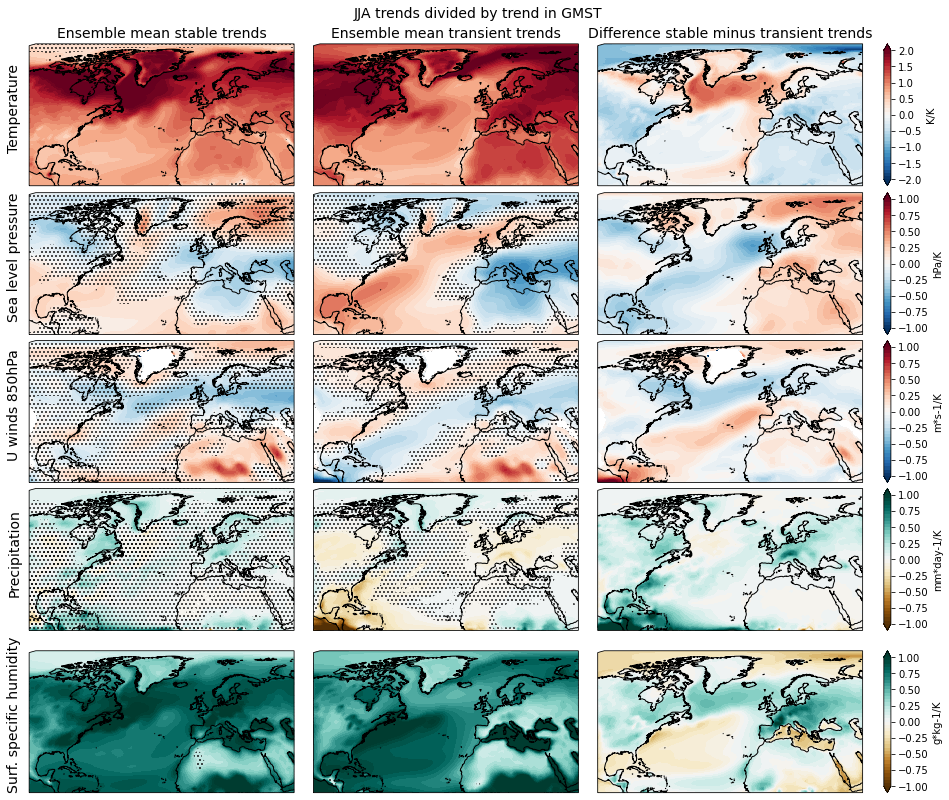

In [36]:
def check_sign_agreement(input):
    print(input.shape)
    pos_neg=np.where((input > 0)&(~np.isnan(input)), 1.0, -1.0)
    values=np.sum(pos_neg,axis=0)
    return(values)

import matplotlib.colors as colors
f=plt.figure()
crs = ccrs.Robinson(central_longitude=0., globe=None)
colormap={'tas':plt.cm.RdBu_r,'pr':plt.cm.BrBG,'psl':plt.cm.RdBu_r,'ua_850':plt.cm.RdBu_r,'huss':plt.cm.BrBG,'prw':plt.cm.BrBG,'hurs':plt.cm.BrBG,'evspsbl':plt.cm.BrBG,'mrso':plt.cm.BrBG,'mrsos':plt.cm.BrBG}
scale={'pr':1,'tas':2,'psl':plt.cm.RdBu_r,'psl':1.,'ua_850':1,'huss':1.,'prw':5,'hurs':2,'evspsbl':2,'mrso':20,'mrsos':3}
var=['tas','psl','ua_850','pr','huss','evspsbl','hurs','mrsos']
varname=['Temperature','Sea level pressure','U winds 850hPa','Precipitation','Surf. specific humidity','evspsbl','hurs','mrsos']
units=['K/K','hPa/K','m*s-1/K','mm*day-1/K','g*kg-1/K','evspsbl','hurs','mrsos']
vmin = -3 
vmax = 3
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
n=0
nvars=5
reg='euro'
def plot_background(ax):
    if (reg=='global'):
        ax.set_global()
    else:
    # reg='euro'
        ax.set_extent([-100,50,10,90])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.)
    ax.set_anchor('S')
    # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #               linewidth=1, color='black', alpha=1) #, linestyle='')
    # gl.top_labels = False
    # gl.bottom_labels = False
    # gl.left_labels = False
    # gl.right_labels = False
    # gl.xlines = False
    # gl.ylocator = mticker.FixedLocator([0])
    return ax

fig, axarr = plt.subplots(nrows=nvars, ncols=3, figsize=(13, 2.2*nvars), constrained_layout=True, subplot_kw={'projection': crs}) # figsize width then height
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
for var in var[0:nvars]:
    print(var)
    print(n)
    cf1 = axlist[3*n].contourf(lon[var],lat[var],np.mean(trend[var]/global_trend[var][0:trend[var].shape[0],],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    axlist[3*n].contourf(lon[var],lat[var],check_sign_agreement(trend[var]/global_trend[var][0:trend[var].shape[0],]),levels=[-7,-4.5,0,4.5,7],hatches=["","...","...",""],transform=ccrs.PlateCarree(),colors=None,alpha=0,edgecolor='red') #,extend="both")
    # if (var == 'ua_850'):
    #     cf2 = axlist[6].contour(stable[var].lon,stable[var].lat,np.mean(stable[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
    if (n == 0):
        axlist[3*n].set_title('Ensemble mean stable trends',fontsize=14)
    cf1 = axlist[(3*n)+1].contourf(lon[var],lat[var],np.mean(transient_trend[var]/transient_gtrend[var],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    axlist[(3*n)+1].contourf(lon[var],lat[var],check_sign_agreement(transient_trend[var]/transient_gtrend[var]),levels=[-17,-12.5,0,12.5,17],hatches=["","...","...",""],transform=ccrs.PlateCarree(),colors=None,alpha=0,edgecolor='red')
    if (n == 0):
        axlist[(3*n)+1].set_title('Ensemble mean transient trends',fontsize=14)
    # if (var == 'ua_850'):
    #     cf3 = axlist[7].contour(stable[var].lon,stable[var].lat,np.mean(transient[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
    cf1 = axlist[(3*n)+2].contourf(lon[var],lat[var],np.mean(trend[var]/global_trend[var][0:trend[var].shape[0],],axis=0)-np.mean(transient_trend[var]/transient_gtrend[var],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    if (n == 0):
        axlist[(3*n)+2].set_title('Difference stable minus transient trends',fontsize=14)
    plt.suptitle(seas+" trends divided by trend in GMST",fontsize=14)
    cb1=fig.colorbar(cf1,ax=axlist[(3*n):((3*n)+3)],orientation='vertical',shrink=1,pad=0.025)
    cb1.set_label(units[n]) #,rotation=90,x=0, y=0.5, pad=0, verticalalignment='center',horizontalalignment='center')
    axlist[(3*n)].text(-0.03, 0.55, varname[n], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axlist[3*n].transAxes,fontsize=14)
    # axlist[(3*n)].text(-0.05, 0.55, varname[n], va='bottom', ha='center',
    #     rotation='vertical', rotation_mode='anchor',
    #     transform=axlist[3*n].transAxes,fontsize=14)
    n+=1
# if (var == 'ua_850'):
#     axlist[6].clabel(cf2, cf2.levels, inline=True, fontsize=10)
#     axlist[7].clabel(cf3, cf3.levels[::2], inline=True, fontsize=10)
plt.savefig('paper_plots/trends_EM_'+seas+'_'+reg+'_.png',dpi=300)

In [ ]:
import matplotlib.colors as colors
f=plt.figure()
crs = ccrs.Robinson(central_longitude=0., globe=None)
colormap={'tas':plt.cm.RdBu_r,'pr':plt.cm.BrBG,'psl':plt.cm.RdBu_r,'ua_850':plt.cm.RdBu_r,'huss':plt.cm.BrBG,'prw':plt.cm.BrBG,'hurs':plt.cm.BrBG,'evspsbl':plt.cm.BrBG,'mrso':plt.cm.BrBG,'mrsos':plt.cm.BrBG}
scale={'pr':2,'tas':2,'psl':plt.cm.RdBu_r,'psl':2.,'ua_850':0.2,'huss':0.001,'prw':5,'hurs':2,'evspsbl':2,'mrso':20,'mrsos':3}

vmin = -3 
vmax = 3
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

def plot_background(ax):
    # ax.set_global()
    ax.set_extent([-100,50,10,90])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.)
    ax.set_anchor('S')
    # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #               linewidth=1, color='black', alpha=1) #, linestyle='')
    # gl.top_labels = False
    # gl.bottom_labels = False
    # gl.left_labels = False
    # gl.right_labels = False
    # gl.xlines = False
    # gl.ylocator = mticker.FixedLocator([0])
    return ax

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(13, 7), constrained_layout=True, subplot_kw={'projection': crs}) # figsize width then height
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

for r in np.arange(0,trend.shape[0]):
    cf1 = axlist[r].contourf(lon2,stable[var].lat,(trend[r,]),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
cf1 = axlist[6].contourf(lon2,stable[var].lat,np.mean(trend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
cf2 = axlist[6].contour(stable[var].lon,stable[var].lat,np.mean(stable[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='black')
axlist[6].set_title('EM stable trends')
cf1 = axlist[7].contourf(lon2,stable[var].lat,np.mean(transient_trend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
axlist[7].set_title('EM transient trends')
cf1 = axlist[8].contourf(lon2,stable[var].lat,np.mean(trend,axis=0)-np.mean(transient_trend/transient_gtrend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
axlist[8].set_title('Difference stable minus transient trends')
plt.suptitle(seas+" trends in "+var+" divided by trend in GMST")
fig.colorbar(cf1,ax=axlist[0:9],orientation='vertical',shrink=1)
plt.savefig('paper_plots/unscaled_trends_'+var+'_'+seas+'.png',dpi=300)

In [ ]:
print(stable_r['jet'])
print(gmst2)
for c in np.arange(0,6):
    plt.scatter(np.arange(0,500),(stable_r[var][c,]-stable_r[var][c,].mean('year')).rolling(year=50,center=True).mean())
plt.axhline(y=0)

In [ ]:
# import matplotlib.colors as colors
# f=plt.figure()
# crs = ccrs.Robinson(central_longitude=0., globe=None)
# colormap={'tas':plt.cm.RdBu_r,'pr':plt.cm.BrBG,'psl':plt.cm.RdBu_r,'ua_850':plt.cm.RdBu_r,'huss':plt.cm.BrBG,'prw':plt.cm.BrBG,'hurs':plt.cm.BrBG,'evspsbl':plt.cm.BrBG,'mrso':plt.cm.BrBG,'mrsos':plt.cm.BrBG}
# scale={'pr':2,'tas':2,'psl':plt.cm.RdBu_r,'psl':2.,'ua_850':2,'huss':0.001,'prw':5,'hurs':2,'evspsbl':2,'mrso':20,'mrsos':3}

# vmin = -3 
# vmax = 3
# norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

# def plot_background(ax):
#     # if (reg=='glob'):
#     #     ax.set_global()
#     # else:
#     reg='euro'
#     ax.set_extent([-100,50,10,90])
#     ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.)
#     ax.set_anchor('S')
#     # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#     #               linewidth=1, color='black', alpha=1) #, linestyle='')
#     # gl.top_labels = False
#     # gl.bottom_labels = False
#     # gl.left_labels = False
#     # gl.right_labels = False
#     # gl.xlines = False
#     # gl.ylocator = mticker.FixedLocator([0])
#     return ax

# fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(13, 7), constrained_layout=True, subplot_kw={'projection': crs}) # figsize width then height
# axlist = axarr.flatten()
# for ax in axlist:
#     plot_background(ax)

# for r in np.arange(0,trend.shape[0]):
#     cf1 = axlist[r].contourf(lon2,stable[var].lat,(trend[r,]/global_trend[r,]),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# cf1 = axlist[6].contourf(lon2,stable[var].lat,np.mean(trend/global_trend[0:trend.shape[0],],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# if (var == 'ua_850'):
#     cf2 = axlist[6].contour(stable[var].lon,stable[var].lat,np.mean(stable[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
# axlist[6].set_title('EM stable trends')
# cf1 = axlist[7].contourf(lon2,stable[var].lat,np.mean(transient_trend/transient_gtrend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# axlist[7].set_title('EM transient trends')
# if (var == 'ua_850'):
#     cf3 = axlist[7].contour(stable[var].lon,stable[var].lat,np.mean(transient[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
# cf1 = axlist[8].contourf(lon2,stable[var].lat,np.mean(trend/global_trend[0:trend.shape[0],],axis=0)-np.mean(transient_trend/transient_gtrend,axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
# axlist[8].set_title('Difference stable minus transient trends')
# plt.suptitle(seas+" trends in "+var+" divided by trend in GMST")
# fig.colorbar(cf1,ax=axlist[6:9],orientation='vertical',shrink=1)
# if (var == 'ua_850'):
#     axlist[6].clabel(cf2, cf2.levels, inline=True, fontsize=10)
#     axlist[7].clabel(cf3, cf3.levels[::2], inline=True, fontsize=10)
# plt.savefig('paper_plots/trends_'+var+'_'+seas+'_'+reg+'_.png',dpi=300)
